<a href="https://colab.research.google.com/github/Resia05/unsupervised_learning/blob/main/%D0%9A%D0%BE%D0%BF%D1%96%D1%8F_%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BD%D0%B8%D0%BA%D0%B0_%22LSTM_%D0%B4%D0%BB%D1%8F_%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D1%83%D0%B2%D0%B0%D0%BD%D0%BD%D1%8F_%D1%87%D0%B0%D1%81%D0%BE%D0%B2%D0%B8%D1%85_%D1%80%D1%8F%D0%B4%D1%96%D0%B2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [4]:
# Перетворення стовпця "Passengers" у формат numpy.ndarray з типом float32
passengers_data = df['Passengers'].values.astype('float32')
passengers_data

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [5]:
# Визначення індексу для поділу (67% на тренувальний набір)
train_size = int(len(passengers_data) * 0.67)

# Поділ на тренувальні та валідаційні дані
train_data = passengers_data[:train_size]
val_data = passengers_data[train_size:]

# Перевірка розмірів наборів
print(f"Розмір тренувального набору: {len(train_data)}")
print(f"Розмір валідаційного набору: {len(val_data)}")


Розмір тренувального набору: 96
Розмір валідаційного набору: 48


**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [12]:
import torch
import numpy as np

def create_dataset(dataset, lookback=1):
    X, y = [], []

    # Проходимо по всьому масиву з урахуванням lookback
    for i in range(len(dataset) - lookback):
        window = dataset[i:(i + lookback)]
        X.append(window)
        y.append(dataset[i + lookback])

    # Перетворюємо списки в numpy масиви для підвищення швидкості
    X = np.array(X)
    y = np.array(y)

    # Перетворюємо numpy масиви у тензори PyTorch
    X = torch.tensor(X)
    y = torch.tensor(y).unsqueeze(1)  # Додаємо зайву розмірність для цільових значень

    return X, y

In [13]:
lookback = 1
X_train, y_train = create_dataset(train_data, lookback=lookback)
X_test, y_test = create_dataset(val_data, lookback=lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [17]:
import torch.nn as nn

# Визначення класу AirModel на основі LSTM
class AirModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(AirModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Переконайтеся, що x має форму [batch_size, sequence_length, input_size]
        if x.dim() == 2:  # Якщо x має форму [batch_size, 1]
            x = x.unsqueeze(1)  # Додаємо розмірність

        lstm_out, _ = self.lstm(x)  # ігноруємо приховані стани
        output = self.linear(lstm_out[:, -1, :])  # беремо тільки останню точку для прогнозу
        return output

# Створюємо модель
model = AirModel(input_size=1, hidden_size=50, num_layers=1)

# Тестуємо модель на одному вході
test_input = torch.tensor([[112.]], dtype=torch.float32).unsqueeze(0)  # Додаємо розмір батчу
output = model(test_input)
print(output)

tensor([[0.2696]], grad_fn=<AddmmBackward0>)


**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [18]:
from torch.utils.data import TensorDataset, DataLoader

# Створюємо TensorDataset на основі X_train та y_train
train_dataset = TensorDataset(X_train, y_train)

# Створюємо DataLoader з батчами по 8 та перемішуванням даних
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

# Перевіряємо, що DataLoader працює
for batch_X, batch_y in train_loader:
    print(f'Batch X: {batch_X}')
    print(f'Batch y: {batch_y}')
    break  # Зупиняємо після першого батчу для перевірки

Batch X: tensor([[199.],
        [129.],
        [191.],
        [233.],
        [277.],
        [178.],
        [201.],
        [269.]])
Batch y: tensor([[199.],
        [121.],
        [172.],
        [267.],
        [317.],
        [199.],
        [204.],
        [270.]])


**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [20]:
import torch.optim as optim

# Ініціалізація моделі
model = AirModel(input_size=1, hidden_size=50, num_layers=1)

# Визначення оптимізатора та функції втрат
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Список для зберігання середніх похибок
losses = []

# Кількість епох
num_epochs = 2000

# Цикл навчання
for epoch in range(num_epochs):
    model.train()  # Переход на тренувальний режим
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        # Обнулення градієнтів
        optimizer.zero_grad()

        # Прямий прохід
        output = model(batch_X)

        # Обчислення втрат
        loss = criterion(output, batch_y)

        # Зворотний прохід
        loss.backward()

        # Оновлення ваг
        optimizer.step()

        # Додаємо втрату до загальної
        epoch_loss += loss.item()

    # Середня втрата на епосі
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    # Валідація раз на 100 епох
    if epoch % 100 == 0:
        model.eval()  # Переход на режим валідації
        train_rmse, test_rmse = 0, 0

        # Валідація на тренувальних даних
        with torch.no_grad():
            for batch_X, batch_y in train_loader:
                output = model(batch_X)
                train_rmse += torch.sqrt(criterion(output, batch_y)).item()

            train_rmse /= len(train_loader)

        # Валідація на тестових даних
        with torch.no_grad():
            output_test = model(X_test)  # Використовуємо X_test
            test_rmse = torch.sqrt(criterion(output_test, y_test)).item()  # Використовуємо y_test

        # Виводимо результати
        print(f'Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}')


Epoch 0: train RMSE 223.5693, test RMSE 422.4164
Epoch 100: train RMSE 184.5529, test RMSE 381.2113
Epoch 200: train RMSE 151.5768, test RMSE 346.9228
Epoch 300: train RMSE 122.7247, test RMSE 314.8175
Epoch 400: train RMSE 100.2470, test RMSE 285.9444
Epoch 500: train RMSE 81.2253, test RMSE 260.0429
Epoch 600: train RMSE 63.6984, test RMSE 235.0665
Epoch 700: train RMSE 52.2158, test RMSE 212.0420
Epoch 800: train RMSE 42.6364, test RMSE 191.3963
Epoch 900: train RMSE 35.0994, test RMSE 172.8494
Epoch 1000: train RMSE 30.1685, test RMSE 157.1363
Epoch 1100: train RMSE 26.5713, test RMSE 143.7413
Epoch 1200: train RMSE 25.7541, test RMSE 133.3161
Epoch 1300: train RMSE 25.2407, test RMSE 124.8870
Epoch 1400: train RMSE 24.5436, test RMSE 117.9592
Epoch 1500: train RMSE 23.3211, test RMSE 113.9873
Epoch 1600: train RMSE 22.7450, test RMSE 109.2287
Epoch 1700: train RMSE 23.2829, test RMSE 105.9526
Epoch 1800: train RMSE 23.0051, test RMSE 103.9404
Epoch 1900: train RMSE 23.5243, test R

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

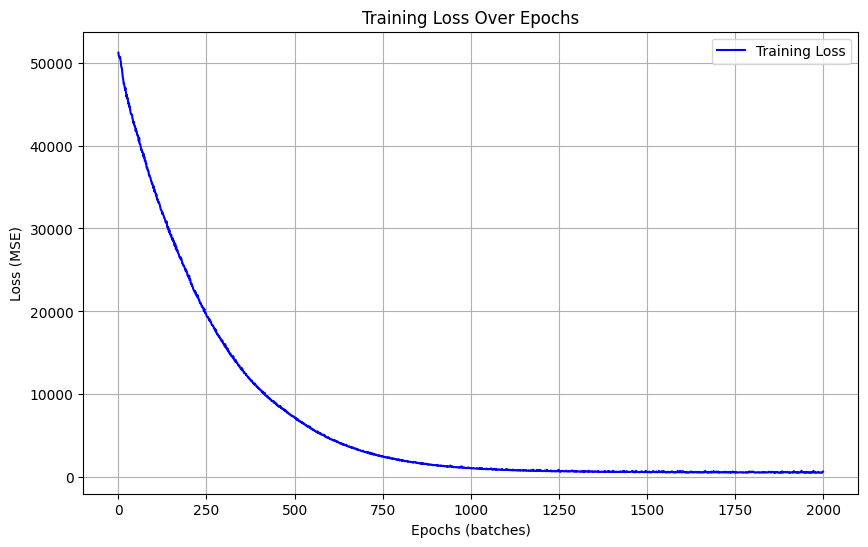

In [21]:
import matplotlib.pyplot as plt

# Побудова графіка лосів
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs (batches)')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()


Загалом, модель демонструє позитивну динаміку у навчанні та зниженні втрат. Якщо тенденція збережеться, модель може стати досить ефективною для прогнозування.

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

In [27]:
# Визначення timeseries з нашого DataFrame
timeseries = passengers_data

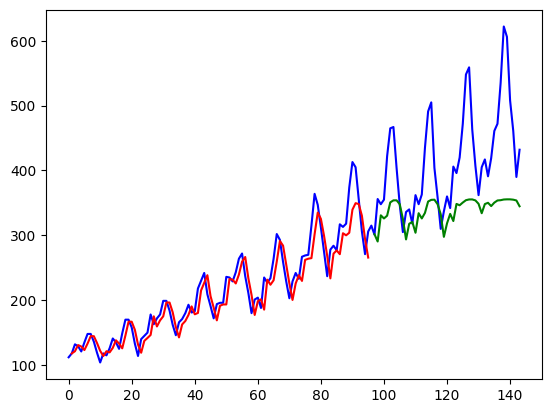

In [28]:
def plot_predicts():
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(timeseries) * np.nan
      test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(timeseries, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts()

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [29]:
# Ініціалізація моделі
model = AirModel(input_size=1, hidden_size=100, num_layers=1)

# Визначення оптимізатора та функції втрат
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Список для зберігання середніх похибок
losses = []

# Кількість епох
num_epochs = 2000

# Цикл навчання
for epoch in range(num_epochs):
    model.train()  # Переход на тренувальний режим
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        # Обнулення градієнтів
        optimizer.zero_grad()

        # Прямий прохід
        output = model(batch_X)

        # Обчислення втрат
        loss = criterion(output, batch_y)

        # Зворотний прохід
        loss.backward()

        # Оновлення ваг
        optimizer.step()

        # Додаємо втрату до загальної
        epoch_loss += loss.item()

    # Середня втрата на епосі
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    # Валідація раз на 100 епох
    if epoch % 100 == 0:
        model.eval()  # Переход на режим валідації
        train_rmse, test_rmse = 0, 0

        # Валідація на тренувальних даних
        with torch.no_grad():
            for batch_X, batch_y in train_loader:
                output = model(batch_X)
                train_rmse += torch.sqrt(criterion(output, batch_y)).item()

            train_rmse /= len(train_loader)

        # Валідація на тестових даних
        with torch.no_grad():
            output_test = model(X_test)  # Використовуємо X_test
            test_rmse = torch.sqrt(criterion(output_test, y_test)).item()  # Використовуємо y_test

        # Виводимо результати
        print(f'Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}')


Epoch 0: train RMSE 222.4265, test RMSE 421.6346
Epoch 100: train RMSE 139.8392, test RMSE 335.7085
Epoch 200: train RMSE 92.6840, test RMSE 276.0660
Epoch 300: train RMSE 60.9394, test RMSE 231.2607
Epoch 400: train RMSE 45.4085, test RMSE 194.6735
Epoch 500: train RMSE 32.9727, test RMSE 166.1276
Epoch 600: train RMSE 26.9544, test RMSE 144.1673
Epoch 700: train RMSE 25.3866, test RMSE 127.8055
Epoch 800: train RMSE 25.3945, test RMSE 117.5580
Epoch 900: train RMSE 23.4343, test RMSE 107.7606
Epoch 1000: train RMSE 22.5697, test RMSE 102.6046
Epoch 1100: train RMSE 22.5216, test RMSE 98.8142
Epoch 1200: train RMSE 22.9772, test RMSE 94.1427
Epoch 1300: train RMSE 23.0111, test RMSE 92.1460
Epoch 1400: train RMSE 22.6337, test RMSE 90.9014
Epoch 1500: train RMSE 23.3404, test RMSE 89.9411
Epoch 1600: train RMSE 22.7289, test RMSE 90.0387
Epoch 1700: train RMSE 22.9641, test RMSE 88.0430
Epoch 1800: train RMSE 22.2554, test RMSE 86.1036
Epoch 1900: train RMSE 22.4450, test RMSE 88.2988

**Тренувальна RMSE:**

У другому наборі з hidden_size=100 тренувальна RMSE (222.4265 на Epoch 0) знижується до 22.4450 на Epoch 1900, що показує значне поліпшення.
У першому наборі з hidden_size=50 RMSE також зменшується (223.5693 на Epoch 0 знижується до 23.5243 на Epoch 1900), але результати не такі вражаючі, як у другому наборі.

**Тестова RMSE:**

У другому наборі тестова RMSE зменшується з 421.6346 на Epoch 0 до 88.2988 на Epoch 1900, що також демонструє значне поліпшення.
У першому наборі тестова RMSE також знижується, але залишається на вищих значеннях (422.4164 на Epoch 0 знижується до 100.6686 на Epoch 1900).
Спостереження:

Другий набір результатів з hidden_size=100 демонструє більш швидке та значне зменшення як тренувальної, так і тестової RMSE порівняно з першим набором, де hidden_size=50.

Це може свідчити про те, що більший hidden_size дозволяє моделі краще вчитися на даних і, відповідно, узагальнювати результати.

**Висновок**

Загалом, другий набір результатів з hidden_size=100 виглядає більш обнадійливо, оскільки модель демонструє краще навчання та узагальнення на тестових даних. Це може бути пов'язано з підвищеною ємністю моделі, яка дозволяє їй краще захоплювати складність даних.

Зробимо ще один тест для покращення якості моделі. В наступному коді реалізовано:

Збільшення кількості шарів LSTM та зміну hidden_size; Регуляризацію за допомогою Dropout; Використання оптимізатора RMSprop.

А також зібрано весь код в один запуск

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Training Original Model:
Epoch 0: test RMSE 422.1708
Epoch 100: test RMSE 379.9864
Epoch 200: test RMSE 344.9369
Epoch 300: test RMSE 312.8955
Epoch 400: test RMSE 283.7630
Epoch 500: test RMSE 257.5422
Epoch 600: test RMSE 232.3257
Epoch 700: test RMSE 209.2902
Epoch 800: test RMSE 188.5415
Epoch 900: test RMSE 170.4101
Epoch 1000: test RMSE 154.3252
Epoch 1100: test RMSE 141.4720
Epoch 1200: test RMSE 131.2805
Epoch 1300: test RMSE 123.4203
Epoch 1400: test RMSE 116.7608
Epoch 1500: test RMSE 111.7857
Epoch 1600: test RMSE 107.4893
Epoch 1700: test RMSE 104.7915
Epoch 1800: test RMSE 102.7269
Epoch 1900: test RMSE 102.4952
Training New Model:
Epoch 0: test RMSE 414.2326
Epoch 100: test RMSE 321.3185
Epoch 200: test RMSE 245.8032
Epoch 300: test RMSE 184.5637
Epoch 400: test RMSE 148.4167
Epoch 500: test RMSE 130.1469
Epoch 600: test RMSE 119.9098
Epoch 700: test RMSE 113.1810
Epoch 800: test RMSE 108.9189
Epoch 900: test RMSE 103.5208
Epoch 1000: test RMSE 105.6832
Epoch 1100: test R

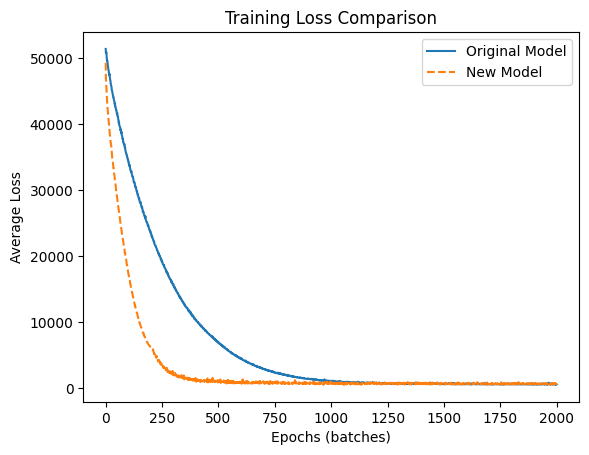

In [30]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)

# Перетворення стовпця "Passengers" у формат numpy.ndarray з типом float32
passengers_data = df['Passengers'].values.astype('float32')

# Визначення індексу для поділу (67% на тренувальний набір)
train_size = int(len(passengers_data) * 0.67)

# Поділ на тренувальні та валідаційні дані
train_data = passengers_data[:train_size]
val_data = passengers_data[train_size:]

# Функція для створення набору даних
def create_dataset(dataset, lookback=1):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        window = dataset[i:(i + lookback)]
        X.append(window)
        y.append(dataset[i + lookback])
    X = np.array(X)
    y = np.array(y)
    X = torch.tensor(X).unsqueeze(-1)  # Додаємо останню розмірність для LSTM
    y = torch.tensor(y).unsqueeze(1)  # Додаємо зайву розмірність для цільових значень
    return X, y

lookback = 1
X_train, y_train = create_dataset(train_data, lookback=lookback)
X_test, y_test = create_dataset(val_data, lookback=lookback)

# Визначення класу моделі з регуляризацією Dropout
class AirModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.2):
        super(AirModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rate)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.linear(lstm_out[:, -1, :])  # Беремо тільки останню точку для прогнозу
        return output

# Ініціалізація оригінальної моделі
model1 = AirModel(input_size=1, hidden_size=50, num_layers=1)
criterion = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

# Ініціалізація нової моделі з змінами
model2 = AirModel(input_size=1, hidden_size=100, num_layers=2)
optimizer2 = optim.RMSprop(model2.parameters(), lr=0.001)

# Створення DataLoader для батчів
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

# Функція для навчання моделі
def train_model(model, optimizer, num_epochs=2000):
    losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        # Валідація раз на 100 епох
        if epoch % 100 == 0:
            model.eval()
            with torch.no_grad():
                output_test = model(X_test)
                test_rmse = torch.sqrt(criterion(output_test, y_test)).item()
                print(f'Epoch {epoch}: test RMSE {test_rmse:.4f}')

    return losses

# Навчання оригінальної моделі
print("Training Original Model:")
losses1 = train_model(model1, optimizer1)

# Навчання нової моделі
print("Training New Model:")
losses2 = train_model(model2, optimizer2)

# Порівняння результатів
plt.plot(losses1, label='Original Model')
plt.plot(losses2, label='New Model', linestyle='--')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs (batches)')
plt.ylabel('Average Loss')
plt.legend()
plt.show()


Порівняння
Початковий RMSE (Epoch 0):

Оригінальна модель: 422.1708
Нова модель: 414.2326
Висновок: Нова модель починає з дещо нижчого RMSE.

Кінець навчання (Epoch 1900):

Оригінальна модель: 102.4952
Нова модель: 91.7312
Висновок: Нова модель досягає нижчого RMSE на тестовому наборі, що свідчить про її кращу якість.

Швидкість навчання:

Нова модель швидше знижує RMSE, досягаючи значних покращень вже на ранніх етапах навчання (порівняно з оригінальною моделлю).
Стабільність:

Оригінальна модель демонструє коливання RMSE на більш пізніх етапах, в той час як нова модель поступово зменшує RMSE без значних коливань.
Загальний висновок
Нова модель, завдяки збільшеній кількості шарів, більшим розміром прихованого шару та використанню регуляризації через Dropout, демонструє значно кращу продуктивність у порівнянні з оригінальною моделлю. Це підтверджує важливість налаштувань архітектури моделі для покращення її якості.